# Combining satellite data with tidal modelling using OTPS <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ls5_usgs_sr_scene](https://explorer.digitalearth.africa/ls5_usgs_sr_scene),
[ls7_usgs_sr_scene](https://explorer.digitalearth.africa/ls7_usgs_sr_scene), 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)

## Background

Ocean tides are the periodic rise and fall of the ocean caused by the gravitational pull of the moon and sun and the earth's rotation. 
Tides in coastal areas can greatly influence how these environments appear in satellite imagery as water levels vary by up to 12 metres.
To be able to study environmental processes along Africa's coastline, it is vital to obtain data on tidal conditions at the exact moment each satellite image was acquired.

## Description
This notebook demonstrates how to tidally tag remotely sensed imagery using functions from the [deafrica_coastaltools script](../Scripts/deafrica_coastaltools.py) so that images can be extracted or analysed by tidal stage (e.g. low, high, ebb, flow). 
These functions use the [OTPS TPXO8 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height (relative to mean sea level) and stage of the tide at the exact moment each satellite image was acquired. 

The notebook demonstrates how to:

1. Load an example time series of satellite data
2. Use the `tidal_tag` function from `deafrica_coastaltools` to model tide heights for each satellite observation
3. Use tide height data to produce median composites of the coast at low and high tide
4. Swap a dataset's dimensions to compute a rolling median along the `tide_height` dimension
5. Compute ebb or flow tide phase data to determine whether water levels were rising or falling in each satellite observation
6. Use the `tidal_stats` function to evaluate any biases in the tidal conditions observed by a satellite

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_coastaltools import tidal_tag
from deafrica_coastaltools import tidal_stats
from deafrica_dask import create_local_dask_cluster

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel.
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:44503 Dashboard: /user/caitlinadams/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


### Connect to the datacube


In [3]:
dc = datacube.Datacube(app='Tidal_modelling')


### Set up data query

First we set up a query to define the area, time period and other parameters required for loading data.
In this example, we will load 30 years of Landsat 5, 7 and 8 data for the Geba River Estuary in southern Guinea-Bissau.
We load the `'red', 'green', 'blue'` bands so that we can plot the data as true colour imagery.

> **Note**: The `dask_chunks` parameter allows us to [use Dask to lazily load data rather than load data directly into memory](https://examples.dask.org/xarray.html), as the standard loading method can take a long time and large amounts of memory.
Lazy loading can be a very useful approach for when you need to load large amounts of data without crashing your analysis.
In coastal applications, it allows us to load (using either `.compute()` or by plotting our data) only a small subset of observations from our entire time series (e.g. only low or high tide observations) without having to load the entire dataset into memory first, which can greatly decrease processing times.

In [4]:
lat, lon = 11.689, -15.674
buffer = 0.15

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('1988-01-01', '2018-12-31'),
    'measurements': ['red', 'green', 'blue'],
    'resolution': (-30, 30), 
    'dask_chunks': {}
}

We can preview the area that we will load data for:

In [5]:
display_map(x=query['x'], y=query['y'])


## Load satellite time-series

To obtain some satellite data to analyse, we use the `load_ard` function to import a time series of Landsat 5, 7 and 8 observations as an `xarray.Dataset`.
The input data does not need to be from Landsat: any remotely-sensed imagery with timestamps and spatial coordinates provide enough data to run the tidal model. 

In [6]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

# Load available data from all three Landsat satellites
ds = load_ard(dc=dc, 
              products=['ls5_usgs_sr_scene', 'ls7_usgs_sr_scene', 'ls8_usgs_sr_scene'],
              output_crs=output_crs,
              align=(15, 15),
              ls7_slc_off=False,
              group_by='solar_day',
              **query)

# Print output data
print(ds)


Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls5_usgs_sr_scene
    ls7_usgs_sr_scene
    Ignoring SLC-off observations for ls7
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Returning 210 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 210, x: 1093, y: 1109)
Coordinates:
  * time         (time) datetime64[ns] 1988-07-17T10:52:47.658038 ... 2018-12-27T11:21:57.806437
  * y            (y) float64 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 0
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


## Model tide heights for each observation

We use the `tidal_tag` function from `deafrica_coastaltools` to associate each satellite observation in our timeseries with a tide height relative to mean sea level.
This function uses the time and date of acquisition and the geographic location of each satellite observation as inputs to the OSU Tidal Prediction Software (OTPS) tidal model.
From [Sagar et al. 2015](https://www.sciencedirect.com/science/article/pii/S0034425717301591):

> **Note**: The **OTPS TPX08** tidal model consists of a multi-resolution bathymetric grid solution, with a 1/6° solution in the global open ocean, and a 1/30° local resolution solution to improve modelling in complex shallow water environments. The OTPS model is based on a system of linear partial differential equations, called Laplace's tidal equations, parametrised with nine harmonic tidal constituents. The model is fitted to track-averaged TOPEX/Poseidon altimeter data collected from 1992 to 2016 and Jason-1 (Poseidon 2) altimeter data from 2002 to 2013, enabling estimation of the tidal height and harmonic constituents at discrete temporal epochs and spatial locations.

In [7]:
# Model tide heights
ds_tidal = tidal_tag(ds)

# Print output data
print(ds_tidal)


Setting tide modelling location from dataset centroid: -15.67, 11.69
<xarray.Dataset>
Dimensions:      (time: 210, x: 1093, y: 1109)
Coordinates:
  * time         (time) datetime64[ns] 1988-07-17T10:52:47.658038 ... 2018-12-27T11:21:57.806437
  * y            (y) float64 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 0
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    tide_height  (time) float64 -0.194 0.168 0.334 0.805 ... 0.535 -0.217 -0.821
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


The function will automatically select a tide modelling location based on the dataset centroid.
It will then output modelled tide heights as a new `tide_height` variable in the `xarray.Dataset` (the variable should appear under `Data variables` above).

We can easily plot this new variable to inspect the range of tide heights observed by the satellites in our timeseries.
In this example, our observed tide heights range from approximately -1.0 to 1.0 m relative to Mean Sea Level:

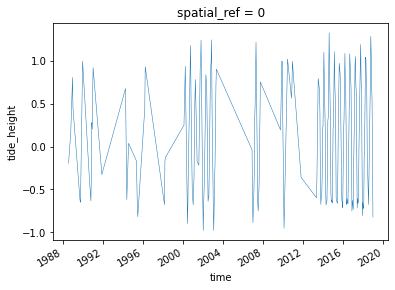

In [8]:
ds_tidal.tide_height.plot(linewidth=0.5)


### Example tide height analysis
To demonstrate how tidally tagged images can be used to produce composites of high and low tide 
imagery, we can compute the lowest 5% and highest 5% percent of tide heights, and use these to filter our observations. 
We can then combine and plot these filtered observations to visualise what the landscape looks like at low and high tide:

> **Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_parallel_processing_with_dask.ipynb).

> **Note**: An alternative approach to combining observations into a composite can be achieved using a geomedian, which ensures band relationships are kept consistent. 
More information is provided in the [Generating geomedian composites notebook](Generating_geomedian_composites.ipynb).

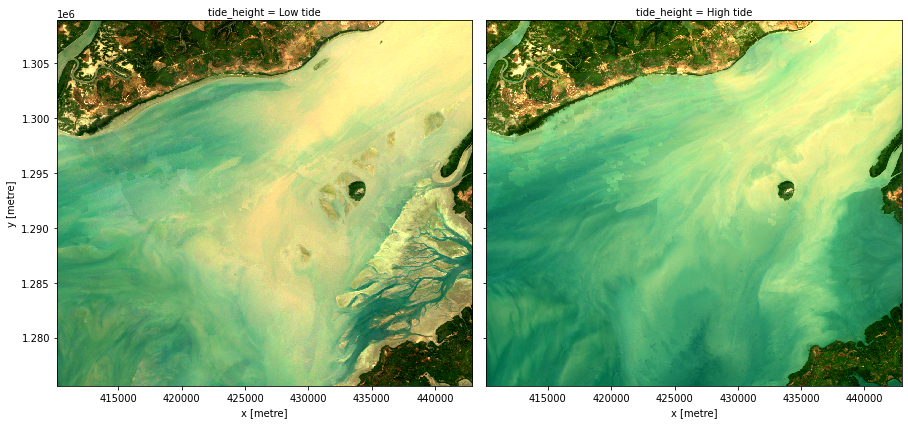

In [9]:
# Calculate the lowest and highest 5% of tides
lowest_5, highest_5 = ds_tidal.tide_height.quantile([0.05, 0.95]).values

# Filter our data to low and high tide observations
filtered_low = ds_tidal.where(ds_tidal.tide_height <= lowest_5, drop=True)
filtered_high = ds_tidal.where(ds_tidal.tide_height >= highest_5, drop=True)

# Take the simple median of each set of low and high tide observations to 
# produce a composite (alternatively, observations could be combined 
# using a geomedian to keep band relationships consistent)
median_low = filtered_low.median(dim='time', keep_attrs=True)
median_high = filtered_high.median(dim='time', keep_attrs=True)

# Combine low and high tide medians into a single dataset and give 
# each layer a meaningful name
ds_highlow = xr.concat([median_low, median_high], dim='tide_height')
ds_highlow['tide_height'] = ['Low tide', 'High tide']

# Plot low and high tide medians side-by-side
rgb(ds_highlow, col='tide_height')


### Swapping dimensions

The `tidal_tag` function allows you to use tide heights as the primary dimension in the dataset, rather than time.
Setting `swap_dims=True` will swap the `time` dimension in the original `xarray.Dataset` to the new `tide_height` variable.

In [10]:
# Model tide heights
ds_tidal = tidal_tag(ds, swap_dims=True)

# Print output data
print(ds_tidal)


Setting tide modelling location from dataset centroid: -15.67, 11.69
<xarray.Dataset>
Dimensions:      (tide_height: 210, x: 1093, y: 1109)
Coordinates:
  * y            (y) float64 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 0
  * tide_height  (tide_height) float64 -0.978 -0.978 -0.952 ... 1.284 1.325
Data variables:
    red          (tide_height, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (tide_height, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (tide_height, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


The dataset now contains three dimensions: `tide_height`, `x` and `y`.

This can make it easier to analyse the data with respect to tide, e.g. computing a rolling median by tide height (e.g. along the `tide_height` dimension), as is done in the following cell.

> **Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_parallel_processing_with_dask.ipynb).

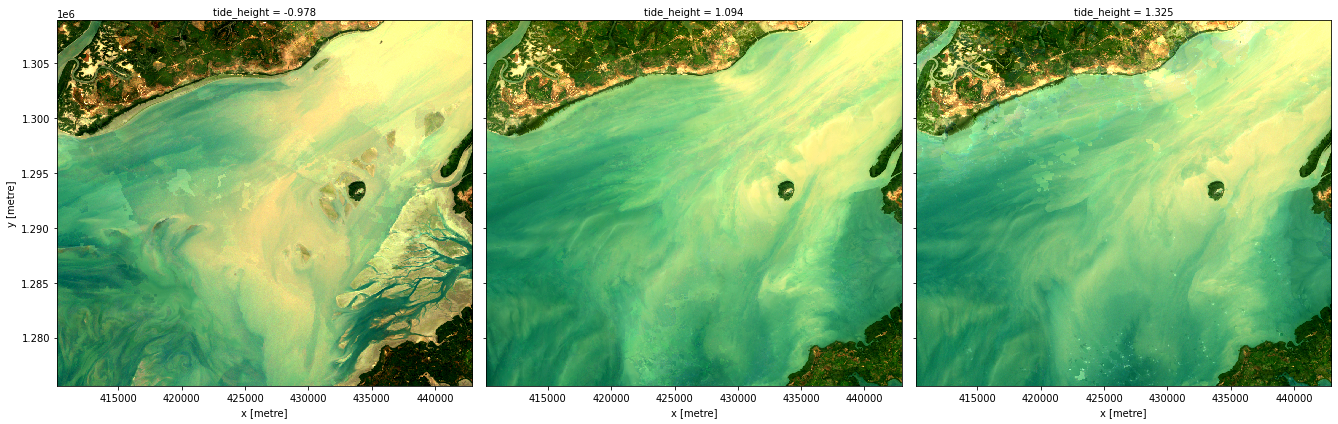

In [11]:
# First we need to update the chunks used by Dask to allow us to do a 
# rolling median without having to load all our data into memory first
ds_rechunked = ds_tidal.chunk(chunks={'tide_height': 15})

# Compute a rolling median that will go through every satellite 
# observation, and take the median of that timestep and its 15 neighbours
ds_rolling = ds_rechunked.rolling(tide_height=15, 
                                  center=True, 
                                  min_periods=1).median()

# Plot the lowest, 200th and highest tide rolling median image
rgb(ds_rolling, index_dim='tide_height', index=[0, 200, -1])


## Modelling ebb and flow tidal phases

The `tidal_tag` function also allows us to determine whether each satellite observation was taken while the tide was rising/incoming (flow tide) or falling/outgoing (ebb tide) by setting `ebb_flow=True`.
This is achieved by comparing tide heights 15 minutes before the before and after the observed satellite observation.

Ebb and flow data can provide valuable contextual information for interpreting satellite imagery, particularly in tidal flat or mangrove forest environments where water may remain in the landscape for considerable time after the tidal peak.

In [12]:
# Model tide heights
ds_tidal = tidal_tag(ds, ebb_flow=True)

# Print output data
print(ds_tidal)


Setting tide modelling location from dataset centroid: -15.67, 11.69
Modelling tidal phase (e.g. ebb or flow)
<xarray.Dataset>
Dimensions:      (time: 210, x: 1093, y: 1109)
Coordinates:
  * time         (time) datetime64[ns] 1988-07-17T10:52:47.658038 ... 2018-12-27T11:21:57.806437
  * y            (y) float64 1.309e+06 1.309e+06 ... 1.276e+06 1.276e+06
  * x            (x) float64 4.102e+05 4.102e+05 ... 4.429e+05 4.429e+05
    spatial_ref  int32 0
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1109, 1093), meta=np.ndarray>
    tide_height  (time) float64 -0.194 0.168 0.334 0.805 ... 0.535 -0.217 -0.821
    ebb_flow     (time) <U4 'Flow' 'Ebb' 'Ebb' 'Flow' ... 'Flow' 'Flow' 'Flow'
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


We now have data giving us the both the tide height and tidal phase ('ebb' or 'flow') for every satellite image:

In [13]:
ds_tidal[['time', 'tide_height', 'ebb_flow']].to_dataframe()


,tide_height,ebb_flow,spatial_ref
time,,,
1988-07-17 10:52:47.658038,-0.194,Flow,0
1988-10-05 10:52:43.680006,0.168,Ebb,0
1988-10-21 10:52:37.662000,0.334,Ebb,0
1988-12-08 10:52:31.815006,0.805,Flow,0
1988-12-24 10:52:23.537063,0.456,Flow,0
...,...,...,...
2018-10-24 11:21:58.388427,1.094,Flow,0
2018-11-09 11:22:01.151598,0.730,Flow,0
2018-11-25 11:22:00.936674,0.535,Flow,0


We could for example use this data to filter our observations to keep ebbing phase observations only:

In [14]:
ds_tidal.where(ds_tidal.ebb_flow == 'Ebb', drop=True)


,Array,Chunk
Bytes,480.01 MB,4.85 MB
Shape,"(99, 1109, 1093)","(1, 1109, 1093)"
Count,1868 Tasks,99 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,480.01 MB,4.85 MB
Shape,"(99, 1109, 1093)","(1, 1109, 1093)"
Count,1868 Tasks,99 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Evaluating observed vs. all modelled tide heights

The complex behaviour of tides mean that a sun synchronous sensor like Landsat [does not observe the full range of the tidal cycle at all locations](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).
Biases in the proportion of the tidal range observed by satellites can prevent us from obtaining data on areas of the coastline exposed or inundated at the extremes of the
tidal range. 
This can risk gaining misleading insights into the true extent of the area of the coastline affected by tides, and make it difficult to compare high or low tide images fairly in different locations.

The `tidal_stats` function can assist in evaluating how the range of tides observed by satellites compare to the full tidal range.
It works by using the OTPS tidal model to model tide heights at a regular interval (every two hours by default) across the entire time period covered by the input satelliter timeseries dataset.
This is then compared against the tide heights in observed by the satellite and used to calculate a range of statistics and a plot that summarises potential biases in the data.

> **Note**: For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the ['Limitations and future work' section in Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3).


Setting tide modelling location from dataset centroid: -15.67, 11.69

79% of the full 2.91 m modelled tidal range is observed at this location.
The lowest 14% and highest 7% of tides are never observed.

Observed tides do not increase or decrease significantly over the ~31 year period.
All tides do not increase or decrease significantly over the ~31 year period.


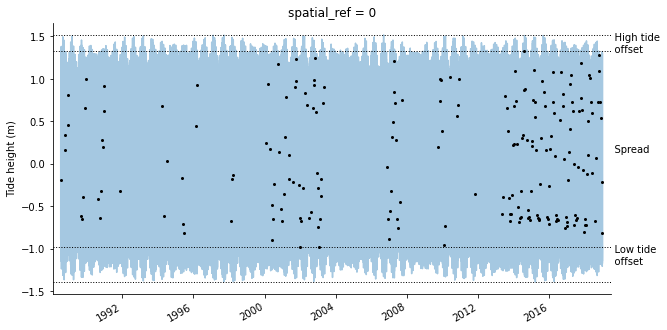

In [15]:
out_stats = tidal_stats(ds)


The function also outputs a `pandas.Series` object containing a set of statistics that compare the observed vs. full modelled tidal ranges.
These statistics include: 

* **tidepost_lat:** latitude used for modelling tide heights
* **tidepost_lon:** longitude used for modelling tide heights
* **observed_min_m:** minimum tide height observed by the satellite (in metre units)
* **all_min_m:** minimum tide height from full modelled tidal range (in metre units)
* **observed_max_m:** maximum tide height observed by the satellite (in metre units)
* **all_max_m:** maximum tide height from full modelled tidal range (in metre units)
* **observed_range_m:** tidal range observed by the satellite (in metre units)
* **all_range_m:** full modelled tidal range (in metre units)
* **spread_m:** proportion of the full modelled tidal range observed by the satellite (see Bishop-Taylor et al. 2018)
* **low_tide_offset:** proportion of the lowest tides never observed by the satellite (see Bishop-Taylor et al. 2018)
* **high_tide_offset:** proportion of the highest tides never observed by the satellite (see Bishop-Taylor et al. 2018)
* **observed_slope:** slope of any relationship between observed tide heights and time
* **all_slope:** slope of any relationship between all modelled tide heights and time
* **observed_pval:** significance/p-value of any relationship between observed tide heights and time
* **all_pval:** significance/p-value of any relationship between all modelled tide heights and time

In [16]:
print(out_stats)


tidepost_lat        11.689
tidepost_lon       -15.674
observed_mean_m      0.088
all_mean_m           0.000
observed_min_m      -0.978
all_min_m           -1.393
observed_max_m       1.325
all_max_m            1.518
observed_range_m     2.303
all_range_m          2.911
spread               0.791
low_tide_offset      0.143
high_tide_offset     0.066
observed_slope       0.003
all_slope           -0.000
observed_pval        0.571
all_pval             0.370
dtype: float64


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)